In [1]:
import sys
import os
import importlib
import glob
import random
from itertools import combinations

import numpy as np
import scipy
import sklearn

import shap
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import prettypyplot as pplt

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [3]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

In [4]:
cv_trajs = list(
    np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load("../../data/raw_feat/cv_dist_spin_anton2.npy"))

sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load("../../data/raw_feat/feat2_raw_anton2.npy"))

rf161 = list(np.load("../../data/raw_feat/rf161.npy", allow_pickle=True))
rf161.extend(np.load("../../data/raw_feat/rf161_anton2.npy"))
rf161_arr = np.concatenate(rf161)

cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape, rf161_arr.shape)

(4150115, 2) (4150115, 60) (4150115, 3)


In [5]:
# load committors
q = np.load("../../data/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[
    8
]  # 50 ns
w = np.load(
    "../../data/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True
)[0]

In [6]:
sb_ids = [42, 47, 52, 53, 58, 59]
X = torch.Tensor(np.hstack((cv_arr, sb_arr[:, sb_ids], rf161_arr[:, 1:2])))
y = torch.Tensor(np.concatenate(q)).unsqueeze(-1)
print(X.shape, y.shape)

torch.Size([4150115, 9]) torch.Size([4150115, 1])


# Simple feedforward, single layer

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [8]:
class SingleLayerNet(pl.LightningModule):
    """Neural network with a single hidden layer
    and sigmoid activation.
    """

    def __init__(self, input_dim, hidden_dim, output_dim, verbose=False):
        super(SingleLayerNet, self).__init__()
        self.verbose = verbose
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        X, y = batch
        # Compute prediction and loss
        pred = self.net(X)
        loss = F.mse_loss(pred, y)

        if self.verbose:
            self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=4e-3)
        return optimizer
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred = self.net(x)
        loss = F.mse_loss(pred, y)
        self.log("val_loss", loss)
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        pred = self.net(x)
        loss = F.mse_loss(pred, y)
        return loss

In [9]:
input_dim = X.shape[-1]
hidden_dim = input_dim
output_dim = 1
n_layers = 3
net = SingleLayerNet(input_dim, hidden_dim, output_dim, verbose=True)

In [10]:
print(net)

SingleLayerNet(
  (net): Sequential(
    (0): Linear(in_features=9, out_features=9, bias=True)
    (1): ReLU()
    (2): Linear(in_features=9, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [11]:
# 80/15/5 train/val/test split
train_X, val_X, train_y, val_y = sklearn.model_selection.train_test_split(
    X, y, test_size=0.2, random_state=123
)
val_X, test_X, val_y, test_y = sklearn.model_selection.train_test_split(val_X, val_y, test_size=0.25, random_state=123)
print(train_X.shape, val_X.shape, test_X.shape, train_y.shape, val_y.shape, test_y.shape)

torch.Size([3320092, 9]) torch.Size([622517, 9]) torch.Size([207506, 9]) torch.Size([3320092, 1]) torch.Size([622517, 1]) torch.Size([207506, 1])


In [12]:
class CommittorDataset(Dataset):
    def __init__(self, data, q):
        self.data = data
        self.q = q

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (self.data[idx], self.q[idx])

In [13]:
batch_size = 16384
train_dataset = CommittorDataset(train_X, train_y)
train_batches = DataLoader(train_dataset, batch_size=batch_size, num_workers=8, pin_memory=True)
val_dataset = CommittorDataset(val_X, val_y)
val_batches = DataLoader(val_dataset, batch_size=batch_size, num_workers=8, pin_memory=True)
test_dataset = CommittorDataset(test_X, test_y)
test_batches = DataLoader(test_dataset, batch_size=batch_size, num_workers=8, pin_memory=True)

In [14]:
trainer = pl.Trainer(max_epochs=100, gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [26]:
trainer.fit(model=net, train_dataloaders=train_batches, val_dataloaders=val_batches)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 100   
------------------------------------
100       Trainable params
0         Non-trainable params
100       Total params
0.000     Total estimated model params size (MB)


Epoch 0:  84%|████████▍ | 203/241 [00:06<00:01, 32.12it/s, loss=0.00508, v_num=4072598, train_loss_step=0.00502]
Validating: 0it [00:00, ?it/s]
Epoch 1:  85%|████████▍ | 204/241 [00:05<00:00, 37.16it/s, loss=0.00359, v_num=4072598, train_loss_step=0.00364, train_loss_epoch=0.0106]
Validating: 0it [00:00, ?it/s]
Epoch 2:  85%|████████▍ | 204/241 [00:05<00:00, 37.91it/s, loss=0.00324, v_num=4072598, train_loss_step=0.00332, train_loss_epoch=0.00421]
Validating: 0it [00:00, ?it/s]
Epoch 3:  85%|████████▍ | 204/241 [00:06<00:01, 31.17it/s, loss=0.00302, v_num=4072598, train_loss_step=0.00309, train_loss_epoch=0.00338]
Validating: 0it [00:00, ?it/s]
Epoch 4:  85%|████████▍ | 204/241 [00:05<00:00, 39.29it/s, loss=0.00289, v_num=4072598, train_loss_step=0.00296, train_loss_epoch=0.00313]
Validating: 0it [00:00, ?it/s]
Epoch 5:  85%|████████▍ | 204/241 [00:05<00:01, 34.31it/s, loss=0.00281, v_num=4072598, train_loss_step=0.00287, train_loss_epoch=0.00296]
Validating: 0it [00:00, ?it/s]
Epoch 6

# Load model from checkpoint

In [20]:
chk_path = "./lightning_logs/version_4072598/checkpoints/epoch=99-step=20299.ckpt"
hparams = "./lightning_logs/version_4072598/hparams.yaml"
net = SingleLayerNet.load_from_checkpoint(chk_path, input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

In [24]:
trainer.test(net, test_batches)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 100%|██████████| 13/13 [00:01<00:00, 11.28it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 13/13 [00:01<00:00,  8.38it/s]


[{}]

In [25]:
mse = 0
for X, y in iter(test_batches):
    pred = net(X)
    with torch.no_grad():
        mse += F.mse_loss(y, pred)
mse /= len(test_batches)
print(f"MSE: {mse:.3e} / RMSE: {np.sqrt(mse):.<3f}")

MSE: 2.009e-03 / RMSE: 0.044818


In [29]:
with torch.no_grad():
    pred = net(test_X)

In [33]:
from scipy.stats import describe

In [40]:
from sklearn.metrics import r2_score 

Text(0.2, 0.9, 'R$^2$ = 0.985')

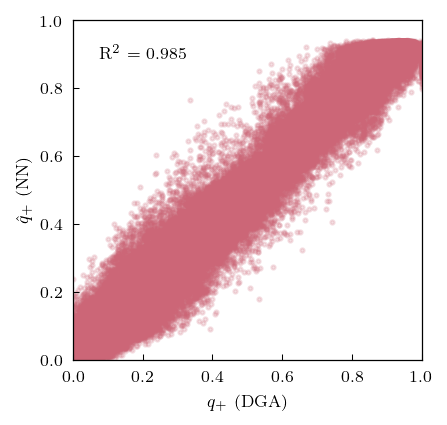

In [41]:
plt.scatter(test_y.squeeze(), pred.squeeze(), alpha=0.2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("$q_+$ (DGA)")
plt.ylabel(r"$\hat{q}_+$ (NN)")
# r, _ = pearsonr(test_y.squeeze(), pred.squeeze())
r = r2_score(test_y.squeeze(), pred.squeeze())
ax = plt.gca()
pplt.text(0.2, 0.9, f"R$^2$ = {r:.3f}", transform=ax.transAxes)

In [45]:
for p in net.parameters():
    print(p)

Parameter containing:
tensor([[-1.2669e-01,  1.5728e-02, -9.8248e-01,  1.4653e+00,  3.0035e-01,
          5.8898e-01, -6.6431e-01, -1.2254e+00,  6.6975e-01],
        [ 2.9154e-01, -9.1086e-03, -1.6756e+00, -3.4329e-02,  1.6491e+00,
         -3.4218e-01, -1.8579e-01, -6.1643e-01,  8.3669e-01],
        [-4.8909e-02,  7.1632e-04,  1.2246e-02, -7.4102e-01, -6.8480e-01,
         -1.5068e+00,  1.0680e+00, -1.0710e+00,  8.5333e-01],
        [ 3.0940e-01,  6.8059e-03, -3.8785e-01, -1.5769e+00,  6.2284e-01,
          2.4213e-02, -2.7662e-02, -1.1251e+00,  6.5041e-01],
        [ 6.4986e-01, -3.0208e-02, -1.2741e+00, -9.9509e-02,  2.5494e+00,
         -8.1484e-01,  3.2920e-01,  7.6784e-01, -1.0658e+00],
        [ 3.0375e-01, -3.2745e-02, -8.0704e-01, -2.3310e+00,  3.3506e-01,
          1.2990e-01,  1.0710e+00, -4.8733e-01,  9.0910e-01],
        [ 8.8705e-02, -1.8888e-03, -8.0582e-01, -1.0005e+00,  6.8523e-01,
         -7.0460e-02,  7.1676e-01,  2.9735e-01, -7.4624e-02],
        [-2.0963e-01,  1.2

In [43]:
for m in net.modules():
    print(m)

SingleLayerNet(
  (net): Sequential(
    (0): Linear(in_features=9, out_features=9, bias=True)
    (1): ReLU()
    (2): Linear(in_features=9, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
Sequential(
  (0): Linear(in_features=9, out_features=9, bias=True)
  (1): ReLU()
  (2): Linear(in_features=9, out_features=1, bias=True)
  (3): Sigmoid()
)
Linear(in_features=9, out_features=9, bias=True)
ReLU()
Linear(in_features=9, out_features=1, bias=True)
Sigmoid()
